# The Mapillary Traffic Sign Dataset for Detection and Classification on a Global Scale - paper review

## Challenges
- traffic signs are easily confused with other object classes in street
- reflection, low light condition, damages, and occlusion
- fine–grained classification
- traffic signs are relatively small in size

## Dataset Statistics
- images: 52,453 fully-anotated 47,547 partialy-anotated
- sign categories: 313 + 1 (other sign)
- total signs: 257 543

| train  | dev   | test   |
|--------|-------|--------|
| 36 589 | 5 320 | 10 544 |

- distribution plots are present in the paper

##  Annotation Process 
The annotations were done by 15 experts trained on this task. The authors continuously controlled the quality of annotations. At least two annotators must have seen each image. To further validate the quality of annotations, they runed separate annotation experiment over smaller subset of images and cross-checked the results showing only minor differences.

### 1. Selection
The images were selected using the following criteria:
- uniform geographical distribution of images around the world (weighted by continent population)
- to cover images of different quality, captured under varying conditions
- to include as many signs as possible per image
- to compensate for the long-tailed distribution of potential traffic
sign classes

### 2. Annotation
The annotation pipeline consisted of 3 steps:
1. Image Approval: the annotators should have ensured that the data fulfil the dataset criteria since the pre-selection was automatically
2. Sign Localization: The bounding boxes were pre-generated automatically. The annotators were asked to verify and adjust the bounding boxes to fit all traffic signs in the image.
3. Sign Classification: The annotators were asked to provide a correct class label for show sign (determined by box). This was not trivial since they used 313 classes. Thereby, the signs were pre-annotated automatically using a proposal network.

## Baseline
- Faster R-CNN with ResNet50 and ResNet101 back-bones
- two tasks: detection only and detection + classification
- ResNet50: 83.4 mAP over all 313 classes
- their best performing approach used 2 stage pipeline: 1. binary object detection, 2. multi-class classification using a decoupled shallow classification network


In [1]:
import os
import numpy as np
import json
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
PATH = "C:/Users/tlust/Downloads/mtsd"

splits_path = os.path.join(PATH, "splits")
images_path = os.path.join(PATH, "images")
annotations_path = os.path.join(PATH, "annotations")

# YOLOv8

In [3]:
DOUBLE_STEP = False

detect_path = os.path.join(PATH, "yolov8", "detect")
cls_path = os.path.join(PATH, "yolov8", "classify")

## Detection dataset
For a single-step process, classify directly into the full taxonomy; if not, employ binary detection.

In [4]:
labels = []

# statistics
rejected = 0
total = 0
sign_distr = {}

for split in ['train', 'val']:
    print("Processing {} split...".format(split))

    # 0. create output directories if not exists
    out_dir = os.path.join(detect_path, split)
    if not os.path.exists(out_dir):
        os.makedirs(os.path.join(out_dir, "images"))
        os.makedirs(os.path.join(out_dir, "labels"))

    with open(os.path.join(splits_path, split + ".txt")) as f:
        ids = f.readlines()

    for id in tqdm(ids, total=len(ids)):
        total += 1    

        # 1. set and validate paths
        id = id.strip()
        img_path = os.path.join(images_path, f"{id}.jpg")
        ann_path = os.path.join(annotations_path, f"{id}.json")
        out_img_path = os.path.join(out_dir, "images", f"{id}.jpg")
        out_ann_path = os.path.join(out_dir, "labels", f"{id}.txt")  

        # 1.2. skip if image or annotation does not exists
        if (not os.path.exists(img_path)) or (not os.path.exists(ann_path)):
            rejected += 1
            continue

        # 2. read annotation 
        with open(ann_path, 'r') as f:
            ann = json.load(f)

        # 2.1 skip if panormaic image
        if ann['ispano'] == True:
            rejected += 1
            continue

        # 3. create annotation file and copy image
        with open(out_ann_path, "a") as f:  
            is_empty = True
            for obj in ann['objects']:
                # 3.1 get label index
                if DOUBLE_STEP:
                    obj['label'] = 'traffic-sign'                    
                else:
                    if obj['label'] == 'other-sign':
                        continue
                    else:
                        obj['label'] = '--'.join(obj['label'].split('--')[1:-1])                      
                    
                if obj['label'] not in labels:
                    labels.append(obj['label'])
                label = labels.index(obj['label'])

                # 3.2 set sign distribution
                sign_distr[label] = sign_distr[label] + 1 if label in sign_distr else 1

                # 3.3 get bounding box
                bbox = obj['bbox']
                x_center = np.clip(((bbox['xmin'] + bbox['xmax']) / 2) / ann['width'], 0, 1)
                y_center = np.clip(((bbox['ymin'] + bbox['ymax'] ) / 2) / ann['height'], 0, 1)
                width = np.clip((bbox['xmax'] - bbox['xmin']) / ann['width'], 0, 1)
                height = np.clip((bbox['ymax'] - bbox['ymin']) / ann['height'], 0, 1)
                obj_ann = f"{label} {x_center} {y_center} {width} {height} \n"

                # 3.4 write annotation
                if width > 0.01 and height > 0.01:
                    is_empty = False
                    f.write(obj_ann)
            
            if is_empty == False:
                # 3.5. copy the image
                shutil.copy(img_path, out_img_path)
            else:
                rejected += 1

# 4. create dataset.yaml
with open(os.path.join(detect_path, "dataset.yaml"), "a") as f:
    f.write("path: {detect_path}\n")
    f.write(f"train: {os.path.join('train', 'images')}\n")
    f.write(f"val: {os.path.join('val', 'images')}\n")
    f.write(f"names:\n")
    for ix, label in enumerate(labels):
        f.write(f"  {ix}: {label}\n")

Processing train split...


100%|██████████| 36589/36589 [01:01<00:00, 593.86it/s]


Processing val split...


100%|██████████| 5320/5320 [00:08<00:00, 618.23it/s]


## Classification dataset
If a two-stage pipeline is chosen, then construct a classification dataset that exclusively includes extracted signs, sorted by their respective labels.

In [ ]:
if DOUBLE_STEP:
    labels = []

    # statistics
    rejected = 0
    total = 0
    sign_distr = {}


    for split in ['train', 'val', 'test']:
        print("Processing {} split...".format(split))
   
        with open(os.path.join(splits_path, split + ".txt")) as f:
            ids = f.readlines()

        for id in tqdm(ids, total=len(ids)):
            total += 1

            # 1. set and validate paths
            id = id.strip()
            img_path = os.path.join(images_path, f"{id}.jpg")
            ann_path = os.path.join(annotations_path, f"{id}.json")
    
            # 1.2. skip if image or annotation does not exists
            if (not os.path.exists(img_path)) or (not os.path.exists(ann_path)):
                rejected += 1
                continue

            # 2. load the image
            img = cv2.imread(img_path)

            # 3. extract traffic sign and create classification dataset                
            with open(ann_path, 'r') as f:
                ann = json.load(f)

            for obj in ann['objects']:
                # 3.1 skip if other-sign
                if obj['label'] == 'other-sign':
                    continue
                # remove --gN suffix
                obj['label'] = '--'.join(obj['label'].split('--')[:-1])

                # 3.2 get sign path and create directory if not exists
                sign_dir = os.path.join(cls_path, split, obj['label'])
                if not os.path.exists(sign_dir):
                    os.makedirs(sign_dir)

                # 3.3 increment sign counter
                if obj['label'] not in labels:
                    labels.append(obj['label'])
                label = labels.index(obj['label'])            
                sign_distr[label] = sign_distr[label] + 1 if label in sign_distr else 1

                # 3.4 get bounding box
                sign = img[
                    int(obj['bbox']['ymin']):int(obj['bbox']['ymax']), 
                    int(obj['bbox']['xmin']):int(obj['bbox']['xmax'])
                ]

                # 3.4 save sign
                if sign.shape[0] > 0 and sign.shape[1] > 0 and sign.shape[2] > 0:
                    sign_path = os.path.join(sign_dir, f"{id}_{obj['key']}.jpg")
                    cv2.imwrite(sign_path, sign)

## 2. view dataset statistics

Images - total: 41909
Images - rejected: 16494 (39.36%)
Signs: dict_values([381, 50, 54, 21, 1789, 1182, 2169, 849, 27, 278, 1451, 210, 96, 236, 1957, 508, 120, 2002, 2713, 3933, 118, 808, 2324, 675, 848, 205, 216, 458, 303, 243, 926, 455, 88, 108, 283, 33, 622, 351, 238, 352, 571, 259, 86, 1146, 180, 981, 153, 2734, 2358, 139, 751, 125, 113, 681, 920, 497, 635, 424, 86, 455, 215, 754, 302, 543, 1065, 699, 1178, 447, 51, 233, 23, 732, 75, 82, 626, 98, 45, 18, 171, 166, 162, 56, 233, 104, 348, 204, 331, 44, 107, 247, 805, 667, 284, 108, 138, 93, 393, 468, 113, 94, 107, 74, 154, 29, 263, 333, 131, 333, 164, 37, 254, 72, 110, 78, 123, 113, 47, 109, 120, 83, 560, 110, 77, 75, 168, 183, 11, 131, 346, 184, 74, 144, 51, 278, 444, 54, 47, 57, 101, 110, 58, 30, 49, 75, 113, 159, 160, 165, 270, 77, 55, 301, 94, 299, 44, 70, 66, 537, 61, 57, 67, 78, 65, 186, 56, 130, 72, 54, 117, 62, 41, 356, 99, 197, 20, 97, 181, 37, 56, 169, 46, 180, 104, 49, 90, 27, 19, 64, 60, 18, 141, 64, 81, 37, 36, 57, 71,

<BarContainer object of 235 artists>

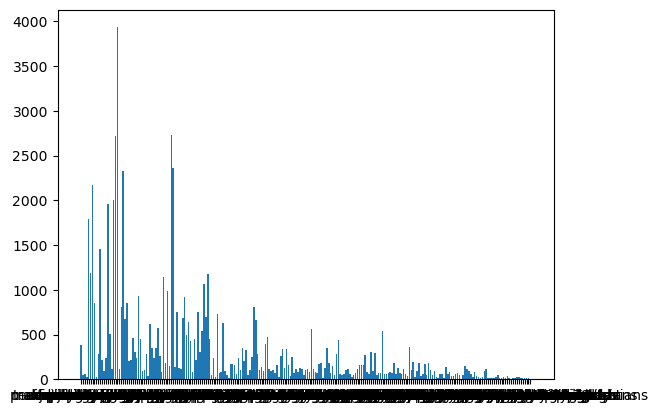

In [6]:
print("Images - total: {}".format(total))
print("Images - rejected: {}".format(rejected) + " ({:.2f}%)".format(rejected / total * 100))
print("Signs: {}".format(np.sum(sign_distr.values())))
for ix, value in sign_distr.items():
    print(f"{labels[ix]}: {value}")
plt.bar(labels, sign_distr.values())

# COCO

In [ ]:
! pip install globox

In [ ]:
from globox import AnnotationSet

In [ ]:
coco_path = os.path.join(PATH, "coco")

In [ ]:
# create dirs if not exists
img_dir = os.path.join(coco_path, "images")
ann_dir = os.path.join(coco_path, "annotations")
if not os.path.exists(ann_dir) or not os.path.exists(img_dir):
    os.makedirs(ann_dir)
    os.makedirs(img_dir)

for split in ['train', 'val']:
    yolo_img_dir = os.path.join(detect_path, split, "images")

    # copy images
    for img_name in os.listdir(yolo_img_dir):
        shutil.copy(
            os.path.join(yolo_img_dir, img_name),
            os.path.join(img_dir, img_name)
        )

    # convert annotations
    yolo = AnnotationSet.from_yolo_v5(
        folder=os.path.join(detect_path, split, "labels"),
        image_folder=yolo_img_dir
    )
    yolo.save_coco(os.path.join(ann_dir, split + ".json"), auto_ids=True)